In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, z_dim):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, z_dim)
        self.fc_logvar = nn.Linear(hidden_dim, z_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        h = self.relu(self.fc1(x))
        return self.fc_mu(h), self.fc_logvar(h)

class Decoder(nn.Module):
    def __init__(self, z_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(z_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, z):
        h = self.relu(self.fc1(z))
        return self.sigmoid(self.fc2(h))

class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, z_dim):
        super(VAE, self).__init__()
        self.encoder = Encoder(input_dim, hidden_dim, z_dim)
        self.decoder = Decoder(z_dim, hidden_dim, input_dim)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        return self.decoder(z), mu, logvar


In [5]:
def vae_loss(reconstructed_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(reconstructed_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

def show_images(images, num_images=16):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 2.5))
    for i in range(num_images):
        ax = axes[i]
        ax.imshow(images[i, 0], cmap='gray')
        ax.axis('off')
    plt.show()


Epoch 1, Loss: 148.82073047688803
Epoch 2, Loss: 116.49382914632162
Epoch 3, Loss: 111.76253055826822
Epoch 4, Loss: 109.67961725260416
Epoch 5, Loss: 108.3586478922526
Epoch 6, Loss: 107.5719480061849
Epoch 7, Loss: 106.924611328125
Epoch 8, Loss: 106.47178080647787
Epoch 9, Loss: 106.05277657063802
Epoch 10, Loss: 105.70299699707031
Epoch 11, Loss: 105.4117817179362
Epoch 12, Loss: 105.13772737630208
Epoch 13, Loss: 104.88377148844401
Epoch 14, Loss: 104.67564367675782
Epoch 15, Loss: 104.47069959309896
Epoch 16, Loss: 104.34077170817058
Epoch 17, Loss: 104.1501359375
Epoch 18, Loss: 103.98521863199869
Epoch 19, Loss: 103.8854786295573
Epoch 20, Loss: 103.73463749593098


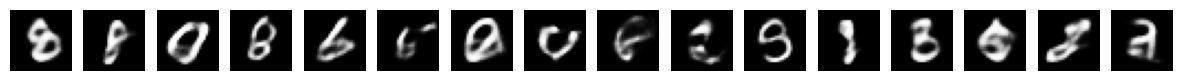

In [6]:
# Define variables
transform = transforms.ToTensor()
mnist_data = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
data_loader = DataLoader(mnist_data, batch_size=64, shuffle=True)

input_dim = 28 * 28
hidden_dim = 400
z_dim = 20
learning_rate = 1e-3
num_epochs = 20

model = VAE(input_dim, hidden_dim, z_dim)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Train
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(data_loader):
        data = data.view(-1, input_dim)
        optimizer.zero_grad()
        reconstructed_batch, mu, logvar = model(data)
        loss = vae_loss(reconstructed_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    print(f'Epoch {epoch+1}, Loss: {train_loss/len(data_loader.dataset)}')

# Evaluate
model.eval()

# Sample and generate
with torch.no_grad():
    z = torch.randn(64, z_dim)
    sample = model.decoder(z).cpu()
    sample = sample.view(64, 1, 28, 28)

show_images(sample.numpy())